In [1]:
# Core DS libraries
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

import mytk # My Toolkit
import wrangle # Helper functions

# Data

In [2]:
# Get training and scoring data
train, test, validate = wrangle.wrangle_potatoes()
train.shape, test.shape, validate.shape

((15942, 25), (5314, 25), (5314, 25))

In [3]:
train_orig = train.copy()

In [4]:
# upsample train
train = mytk.upsample_target(train, 'failure', 1)
train.shape

(25028, 25)

In [5]:
# Load and impute the kaggle submission data
imputeCols = train.select_dtypes(include=np.number).drop(columns='failure').columns.tolist()
from sklearn.impute import SimpleImputer
imputer =  SimpleImputer()
imputer.fit(train[imputeCols])

final = pd.read_csv('./data/test.csv')
final[imputeCols] = imputer.transform(final[imputeCols])
final.isna().sum().sum()

0

In [6]:
def df_expand_dummies(df, col):
    dum = pd.get_dummies(df[col], prefix= df[col].name)
    return pd.concat([df.drop(columns=col), dum], axis= 1)

In [7]:
pd.get_dummies(train.product_code, prefix=train.product_code.name)

,product_code_A,product_code_B,product_code_C,product_code_D,product_code_E
id,,,,,
13066,0,0,1,0,0
22151,0,0,0,0,1
14660,0,0,1,0,0
69,1,0,0,0,0
5901,0,1,0,0,0
...,...,...,...,...,...
11967,0,0,1,0,0
6995,0,1,0,0,0
2181,1,0,0,0,0


In [8]:
train = df_expand_dummies(train, 'product_code')
test = df_expand_dummies(test, 'product_code')
validate = df_expand_dummies(validate, 'product_code')
final = df_expand_dummies(final, 'product_code')

In [9]:
final.head()

,id,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,product_code_F,product_code_G,product_code_H,product_code_I
0,26570,119.57,material_5,material_6,6.0,4.0,6.0,9.0,6.0,19.305,...,13.772,13.659,16.825,13.742,17.710,634.612,1,0,0,0
1,26571,113.51,material_5,material_6,6.0,4.0,11.0,8.0,0.0,17.883,...,12.473,17.468,16.708,14.776,14.102,537.037,1,0,0,0
2,26572,112.16,material_5,material_6,6.0,4.0,8.0,12.0,4.0,18.475,...,10.907,13.363,15.737,17.065,16.021,658.995,1,0,0,0
3,26573,112.72,material_5,material_6,6.0,4.0,8.0,11.0,10.0,16.518,...,10.933,15.501,15.667,12.620,16.111,594.301,1,0,0,0
4,26574,208.00,material_5,material_6,6.0,4.0,14.0,16.0,8.0,17.808,...,11.941,16.070,16.183,13.324,17.150,801.044,1,0,0,0


In [10]:
def encode_variables(df):
    catCols = ['attribute_0','attribute_1','attribute_2','attribute_3']
    for col in catCols:
        df[col] = df[col].astype('category').cat.codes
    return df
# Encode categoricals
train = encode_variables(train)
test = encode_variables(test)
validate = encode_variables(validate)
final = encode_variables(final)

## X / Y splits

In [11]:
tx = train.drop(columns='failure')
ty = train.failure
sx = test.drop(columns='failure')
sy = test.failure
vx = validate.drop(columns='failure')
vy = validate.failure
fx = final

## Feature selection

I predict product_code and measurement_2 to be the strongest predictors.

In [12]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC

estimator = RandomForestClassifier(max_depth=5)
# estimator = QuadraticDiscriminantAnalysis()
# estimator = SVC()


In [13]:
# selector = RFE(estimator=estimator, n_features_to_select=3 )
# selector.fit(tx, ty)
# selector.get_feature_names_out()

In [14]:
# feats = ['loading', 'measurement_2','measurement_3', 'measurement_16' ] +[col for col in train if col.startswith('product_code')]

In [15]:
# tx = tx[feats]
# sx = sx[feats]
# vx = vx[feats]
# # fx = fx[feats]

In [16]:
# Final does not have the same product codes as the rest of the data.  So I can't use product code as a feature.
final.columns[-4:]

Index(['product_code_F', 'product_code_G', 'product_code_H', 'product_code_I'], dtype='object')

In [17]:
feats = ['loading', 'measurement_2','measurement_3', 'measurement_16' ]


In [18]:
feats = [
    'loading',
    'measurement_1',
    'measurement_2',
    'measurement_3',
    'measurement_5',
    'measurement_7',
    'measurement_12',
    'measurement_14',
    'measurement_16',
    'measurement_17',
]

In [19]:
tx = tx[feats]
sx = sx[feats]
vx = vx[feats]
fx = fx[feats]

### Baseline Model

In [20]:
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score


In [21]:
baseline = mytk.BaselineModel(method='mode')
baseline.fit(train_orig.failure)

0.5

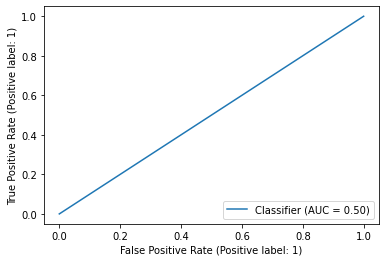

In [22]:
RocCurveDisplay.from_predictions(ty, baseline.predict_proba(ty))

roc_auc_score(ty, baseline.predict(ty))

### Model 1 - RFC

In [23]:
m1 = RandomForestClassifier(max_depth=5)

m1.fit(tx, ty)

p1t = m1.predict_proba(tx)

In [24]:
p1t[:, 1]

array([0.5120764 , 0.47761656, 0.47474742, ..., 0.46789486, 0.53016911,
       0.50247582])

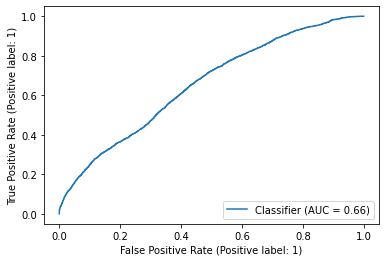

In [25]:
RocCurveDisplay.from_predictions(ty, p1t[:, 1])


In [26]:
roc_auc_score(ty, p1t[:, 1])

0.6554020373001322

In [27]:
mets = {}
for i in range (1, 20):
    rfc = RandomForestClassifier(max_depth=i)
    rfc.fit(tx, ty)
    tp = rfc.predict_proba(tx)[:, 1]
    sp = rfc.predict_proba(sx)[:, 1]
    mets[f'depth_{i}'] = {'train': roc_auc_score(ty, tp),
                            'test': roc_auc_score(sy, sp)}

In [28]:
dfmets = pd.DataFrame.from_dict(mets, 'index')
dfmets

,train,test
depth_1,0.589378,0.584469
depth_2,0.597694,0.588649
depth_3,0.611139,0.588736
depth_4,0.628305,0.590644
depth_5,0.653430,0.588097
depth_6,0.690627,0.586703
depth_7,0.731229,0.585610
depth_8,0.778377,0.581738
depth_9,0.846103,0.575384
depth_10,0.892511,0.572558


<AxesSubplot:>

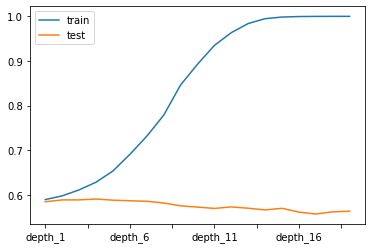

In [29]:
dfmets.plot()

### Model 2 - Nueral Networking

In [30]:
from sklearn.neural_network import MLPClassifier

In [31]:
mlp = MLPClassifier(learning_rate='adaptive')

mlp.fit(tx, ty)


MLPClassifier(learning_rate='adaptive')

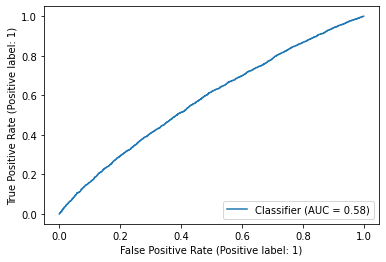

In [32]:
t2p = mlp.predict_proba(tx)[:, 1]
RocCurveDisplay.from_predictions(ty, t2p)

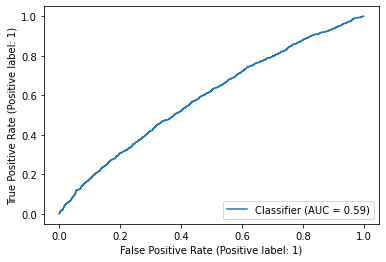

In [33]:
s2p = mlp.predict_proba(sx)[:, 1]
RocCurveDisplay.from_predictions(sy, s2p)

### Model 3 - KNN Classification

In [34]:
scaler = mytk.train_scaler(tx)
scaled_tx = mytk.scale_df(tx, scaler)
scaled_sx = mytk.scale_df(sx, scaler)

In [35]:
from sklearn.neighbors import KNeighborsClassifier

In [36]:
list (range(1,15,5))

[1, 6, 11]

In [37]:
mets = {}
for i in range (150, 206, 5):
    m = KNeighborsClassifier(n_neighbors=i)
    m.fit(scaled_tx, ty)
    tp = m.predict_proba(scaled_tx)[:, 1]
    sp = m.predict_proba(scaled_sx)[:, 1]
    mets[f'{i}'] = {'train': roc_auc_score(ty, tp),
                            'test': roc_auc_score(sy, sp)}

In [38]:
dfmets = pd.DataFrame.from_dict(mets, 'index')
dfmets.head()

,train,test
150,0.610640,0.535277
155,0.608636,0.535674
160,0.607177,0.534626
165,0.608102,0.538144
170,0.607339,0.537887


<AxesSubplot:>

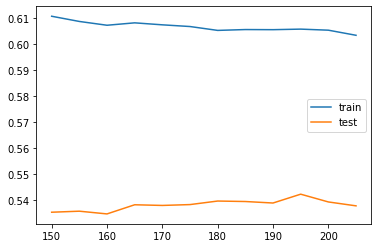

In [39]:
dfmets.plot()

In [40]:
dfmets.test[:20].idxmax()

'195'

In [41]:
m3 = KNeighborsClassifier(n_neighbors=190)
m3.fit(scaled_tx, ty)
tp = m3.predict_proba(scaled_tx)[:, 1]
sp = m3.predict_proba(scaled_sx)[:, 1]

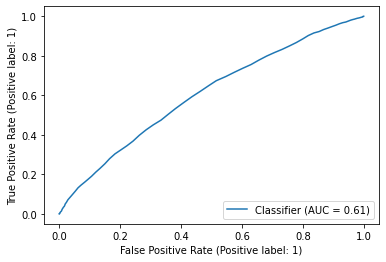

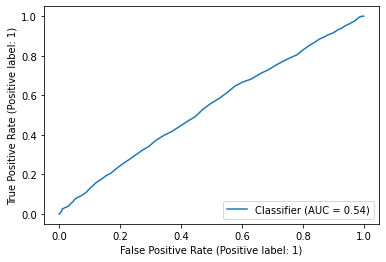

In [42]:
RocCurveDisplay.from_predictions(ty, tp)
RocCurveDisplay.from_predictions(sy, sp)

### Best Model pipeline

In [56]:
from sklearn.neighbors import KNeighborsClassifier


In [57]:
# feats = [
#     'loading',
#     'measurement_1',
#     'measurement_2',
#     'measurement_3',
#     'measurement_5',
#     'measurement_7',
#     'measurement_12',
#     'measurement_14',
#     'measurement_16',
#     'measurement_17',
# ]

In [58]:
train, test, validate = wrangle.wrangle_potatoes()
feats = ['loading', 'measurement_2','measurement_3', 'measurement_16' ] 
target = 'failure'
train = mytk.upsample_target(train, 'failure', 1)

In [59]:
scaler = mytk.train_scaler(train[feats])


In [60]:
tx = mytk.scale_df(train[feats], scaler)
sx = mytk.scale_df(test[feats], scaler)
vx = mytk.scale_df(validate[feats], scaler)
fx = mytk.scale_df(final[feats], scaler)

In [61]:
ty = train[target]
sy = test[target]
vy = validate[target]

In [62]:
model = KNeighborsClassifier(n_neighbors=190)
model.fit(tx, ty)

KNeighborsClassifier(n_neighbors=190)

In [63]:
vp = model.predict_proba(vx)[:, 1]

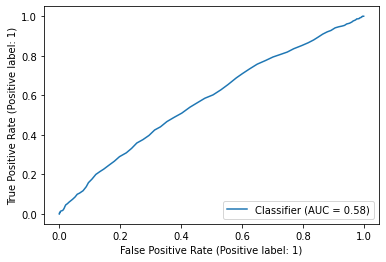

In [64]:
RocCurveDisplay.from_predictions(vy, vp)

In [65]:
final.head()

,id,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,product_code_F,product_code_G,product_code_H,product_code_I,failure
0,26570,119.57,0,1,0,0,6.0,9.0,6.0,19.305,...,13.659,16.825,13.742,17.710,634.612,1,0,0,0,0.473684
1,26571,113.51,0,1,0,0,11.0,8.0,0.0,17.883,...,17.468,16.708,14.776,14.102,537.037,1,0,0,0,0.368421
2,26572,112.16,0,1,0,0,8.0,12.0,4.0,18.475,...,13.363,15.737,17.065,16.021,658.995,1,0,0,0,0.389474
3,26573,112.72,0,1,0,0,8.0,11.0,10.0,16.518,...,15.501,15.667,12.620,16.111,594.301,1,0,0,0,0.463158
4,26574,208.00,0,1,0,0,14.0,16.0,8.0,17.808,...,16.070,16.183,13.324,17.150,801.044,1,0,0,0,0.636842


In [66]:
fp = model.predict_proba(fx)[:, 1]

In [67]:
fp

array([0.36842105, 0.40526316, 0.44210526, ..., 0.51578947, 0.48421053,
       0.38421053])

In [68]:
final['failure'] = fp

In [69]:
final[['id','failure']].to_csv('sumission.csv', index=False)